In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.9.1
sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.3
sklearn 1.1.1
tensorflow 2.9.1
keras.api._v2.keras 2.9.0


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [15]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
# 先reshape变为一维的目的是对每一个像素点进行标准化
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


In [17]:
# 批归一化为了防止梯度消失
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.BatchNormalization())
    """
    #也可以把激活函数放在批归一化的后面
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    """
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

In [18]:
model.summary()  # 400=层数400 * 4，4是代表4个参数:gamma,beta,moving_mean,moving_variance

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_21 (Dense)            (None, 100)               78500     
                                                                 
 batch_normalization_20 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_22 (Dense)            (None, 100)               10100     
                                                                 
 batch_normalization_21 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_23 (Dense)            (None, 100)              

In [19]:
model.variables

[<tf.Variable 'dense_21/kernel:0' shape=(784, 100) dtype=float32, numpy=
 array([[ 0.03663272,  0.02208513,  0.03178259, ...,  0.01795511,
         -0.05881985,  0.06862919],
        [-0.00803589, -0.06557789, -0.08120539, ...,  0.00369892,
         -0.07313605,  0.06616522],
        [-0.07669299, -0.07552768,  0.06918994, ..., -0.05521253,
         -0.06588345, -0.06513298],
        ...,
        [ 0.0257682 ,  0.05576718, -0.04056732, ..., -0.03599566,
          0.04295091,  0.06172702],
        [-0.00024303,  0.05811109,  0.03610971, ..., -0.0507102 ,
          0.05160791, -0.02277002],
        [-0.01764529, -0.01374403,  0.01936571, ..., -0.02725431,
         -0.01700304, -0.03014104]], dtype=float32)>,
 <tf.Variable 'dense_21/bias:0' shape=(100,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [20]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir = './dnn-bn-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2),
]
history = model.fit(x_train_scaled, y_train, epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Epoch 1/100


2022-07-21 22:52:31.387778: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.


1719/1719 [==============================] - 12s 5ms/step - loss: 1.8579 - accuracy: 0.3753 - val_loss: 0.9896 - val_accuracy: 0.6486
Epoch 2/100
1719/1719 [==============================] - 9s 5ms/step - loss: 1.0967 - accuracy: 0.6149 - val_loss: 0.7891 - val_accuracy: 0.7210
Epoch 3/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.9595 - accuracy: 0.6589 - val_loss: 0.6901 - val_accuracy: 0.7532
Epoch 4/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.8778 - accuracy: 0.6847 - val_loss: 0.6460 - val_accuracy: 0.7698
Epoch 5/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.8335 - accuracy: 0.7008 - val_loss: 0.6071 - val_accuracy: 0.7832
Epoch 6/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7898 - accuracy: 0.7196 - val_loss: 0.5676 - val_accuracy: 0.7894
Epoch 7/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7545 - accuracy: 0.7316 - val_loss: 0.5544 - val_accuracy: 0.8

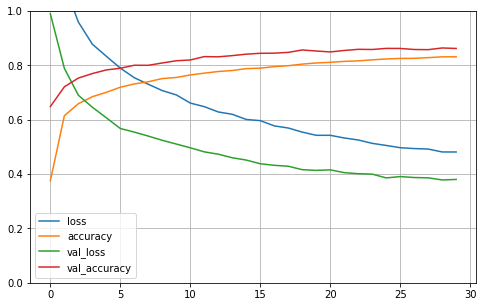

In [21]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

# 1. 参数众多，训练不充分
# 2. 梯度消失 -> 链式法则 -> 复合函数f(g(x))
#    批归一化缓解梯度消失

In [22]:
model.evaluate(x_test_scaled, y_test, verbose=0)

[0.41457831859588623, 0.8546000123023987]